<a href="https://colab.research.google.com/github/GursimarSaini/INSE6310Project/blob/main/PredictiveMaintenanceRUL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pycaret==2.3.6

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached MarkupSafe-2.1.1-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (25 kB)
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 2.0.1
    Uninstalling MarkupSafe-2.0.1:
      Successfully uninstalled MarkupSafe-2.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [2]:
!pip install markupsafe==2.0.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached MarkupSafe-2.0.1-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (31 kB)
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 2.1.1
    Uninstalling MarkupSafe-2.1.1:
      Successfully uninstalled MarkupSafe-2.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 3.2.0 requires markupsafe~=2.1.1, but you have markupsafe 2.0.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [3]:
import pandas as pd
import numpy as np
#from pca import pca
import jinja2
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline  

from pycaret.regression import *

import seaborn as sns
sns.set(style="ticks", color_codes=True)

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

sns.set_theme(style="darkgrid")
plt.rcParams['figure.figsize'] = (13,8)


/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


## Data Description

### The dataset consists of 10 000 data points stored as rows with 14 features in columns

##### UID: unique identifier ranging from 1 to 10000
##### product ID: consisting of a letter L, M, or H for low (50% of all products), medium (30%) and high (20%) as product quality variants and a variant-specific serial number
##### air temperature [K]: generated using a random walk process later normalized to a standard deviation of 2 K around 300 K
##### process temperature [K]: generated using a random walk process normalized to a standard deviation of 1 K, added to the air temperature plus 10 K.
##### rotational speed [rpm]: calculated from a power of 2860 W, overlaid with a normally distributed noise
##### torque [Nm]: torque values are normally distributed around 40 Nm with a Ïƒ = 10 Nm and no negative values.
##### tool wear [min]: The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process. and a
##### 'machine failure' label that indicates, whether the machine has failed in this particular datapoint for any of the following failure modes are true.


###  The machine failure consists of five independent failure modes

##### tool wear failure (TWF): the tool will be replaced of fail at a randomly selected tool wear time between 200-240 mins (120 times in our dataset). At this point in time, the tool is replaced 69 times, and fails 51 times (randomly assigned).
##### heat dissipation failure (HDF): heat dissipation causes a process failure, if the difference between air- and process temperature is below 8.6 K and the tool's rotational speed is below 1380 rpm. This is the case for 115 data points.
##### power failure (PWF): the product of torque and rotational speed (in rad/s) equals the power required for the process. If this power is below 3500 W or above 9000 W, the process fails, which is the case 95 times in our dataset.
##### overstrain failure (OSF): if the product of tool wear and torque exceeds 11,000 minNm for the L product variant (12,000 M, 13,000 H), the process fails due to overstrain. This is true for 98 datapoints.
##### random failures (RNF): each process has a chance of 0,1 % to fail regardless of its process parameters. This is the case for only 5 datapoints, less than could be expected for 10,000 datapoints in our dataset.

##### If at least one of the above failure modes is true, the process fails and the 'machine failure' label is set to 1. It is therefore not transparent to the machine learning method, which of the failure modes has caused the process to fail



# Loading Data

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/GursimarSaini/INSE6310Project/main/data/ai4i2020.csv')
# For multiclass labeling

In [5]:
df = df.drop(columns=["UDI", "ProductID",	"Type", "TWF","HDF","PWF","OSF","RNF"])
df.head(10)

,AirTemperature[K],ProcessTemperature[K],RotationalSpeed[rpm],Torque[Nm],ToolWear[min],MachineFailure
0,298.1,308.6,1551,42.8,0,0
1,298.2,308.7,1408,46.3,3,0
2,298.1,308.5,1498,49.4,5,0
3,298.2,308.6,1433,39.5,7,0
4,298.2,308.7,1408,40.0,9,0
5,298.1,308.6,1425,41.9,11,0
6,298.1,308.6,1558,42.4,14,0
7,298.1,308.6,1527,40.2,16,0
8,298.3,308.7,1667,28.6,18,0
9,298.5,309.0,1741,28.0,21,0


# EDA

In [6]:
df.info()
print("Number of duplicated rows is: ", df.duplicated().sum())
print("Number of rows with NaNs is: ", df.isna().any(axis=1).sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   AirTemperature[K]      10000 non-null  float64
 1   ProcessTemperature[K]  10000 non-null  float64
 2   RotationalSpeed[rpm]   10000 non-null  int64  
 3   Torque[Nm]             10000 non-null  float64
 4   ToolWear[min]          10000 non-null  int64  
 5   MachineFailure         10000 non-null  int64  
dtypes: float64(3), int64(3)
memory usage: 468.9 KB
Number of duplicated rows is:  0
Number of rows with NaNs is:  0


# Remaining Useful Life

In [7]:
dfTW = df['ToolWear[min]']
dfTW = dfTW.to_list()

unit_number = []
j=1
for i in range(len(dfTW)-1):
  if dfTW[i+1] < dfTW[i]:
    j = j+1
  unit_number.append(j)
unit_number.append(unit_number[-1])
df['unit_number'] = unit_number

In [8]:
def add_RUL(df):
    group_unit = df.groupby(by='unit_number') 
    maxCyc = group_unit['ToolWear[min]'].max() 
    result = df.merge(maxCyc.to_frame(name='maxCyc'), left_on='unit_number', right_index=True)
    # Calculate remaining useful life for each row 
    RUL = result["maxCyc"] - result['ToolWear[min]']
    result["RUL"] = RUL
    # drop maxCycle as it's no longer needed 
    result = result.drop(columns=["maxCyc"]) 
    return result

In [9]:
df = add_RUL(df)
df.head(10)

,AirTemperature[K],ProcessTemperature[K],RotationalSpeed[rpm],Torque[Nm],ToolWear[min],MachineFailure,unit_number,RUL
0,298.1,308.6,1551,42.8,0,0,1,206
1,298.2,308.7,1408,46.3,3,0,1,203
2,298.1,308.5,1498,49.4,5,0,1,201
3,298.2,308.6,1433,39.5,7,0,1,199
4,298.2,308.7,1408,40.0,9,0,1,197
5,298.1,308.6,1425,41.9,11,0,1,195
6,298.1,308.6,1558,42.4,14,0,1,192
7,298.1,308.6,1527,40.2,16,0,1,190
8,298.3,308.7,1667,28.6,18,0,1,188
9,298.5,309.0,1741,28.0,21,0,1,185


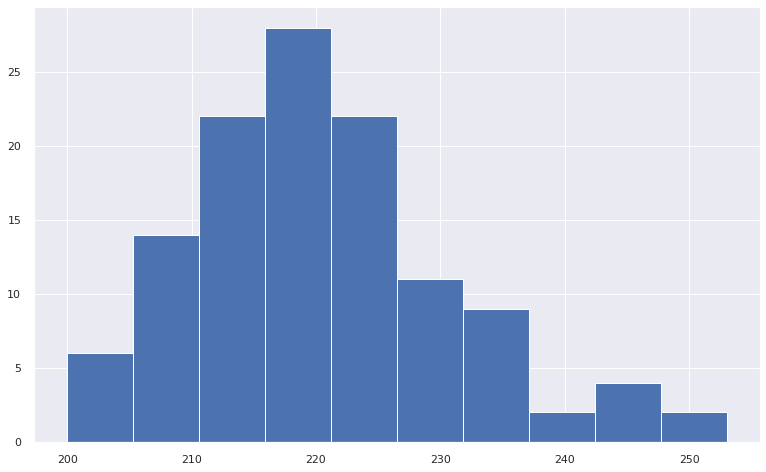

In [10]:
maxRUL = df.groupby('unit_number').max().reset_index()
maxRUL["RUL"].hist()

In [11]:
df["RUL"].describe()

count    10000.000000
mean       112.873800
std         63.971355
min          0.000000
25%         58.000000
50%        113.000000
75%        168.000000
max        253.000000
Name: RUL, dtype: float64

In [12]:
df=df.drop(columns=["unit_number"])

# Regression

In [13]:
data = df
data.reset_index(drop=True, inplace=True)
print('Data for Modeling: ' + str(data.shape))

Data for Modeling: (10000, 7)


In [14]:
reg = setup(data = data, target = 'RUL', session_id=666) 

,Description,Value
0,session_id,666
1,Target,RUL
2,Original Data,"(10000, 7)"
3,Missing Values,False
4,Numeric Features,5
5,Categorical Features,1
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(6999, 6)"


In [15]:
bestModelREG = compare_models()
bestModelREG

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,5.8092,57.5124,7.5794,0.9859,0.2813,0.1133,0.097
gbr,Gradient Boosting Regressor,6.9021,79.0523,8.8876,0.9807,0.3051,0.1333,0.404
rf,Random Forest Regressor,7.2747,88.0504,9.3805,0.9784,0.3079,0.1388,1.560
lr,Linear Regression,7.9804,108.7633,10.4257,0.9734,0.3381,0.1591,0.236
ridge,Ridge Regression,7.9804,108.7631,10.4257,0.9734,0.3381,0.1591,0.010
lar,Least Angle Regression,7.9804,108.7633,10.4257,0.9734,0.3381,0.1591,0.012
en,Elastic Net,8.0036,109.0611,10.4398,0.9733,0.3346,0.1591,0.011
br,Bayesian Ridge,7.9801,108.7855,10.4267,0.9733,0.3366,0.1588,0.011
lasso,Lasso Regression,8.0214,109.3077,10.4515,0.9732,0.3346,0.1595,0.012
huber,Huber Regressor,7.9772,109.8956,10.4799,0.9731,0.3352,0.1549,0.055


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=666, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [16]:
evaluate_model(bestModelREG)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…